In [3]:
import numpy as np
from tqdm.notebook import tqdm
import astropy.constants as const
import pylab as plt
from astropy.modeling import models
from astropy import units as u
from astropy.visualization import quantity_support

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "cm",
      "font.size" : "12",
      "figure.figsize" : [16,8]}
plt.rcParams.update(rc)

%config InlineBackend.figure_format='retina'

import sys
sys.setrecursionlimit(10000)

# Build a model that can explain the emission of galaxies in the optical band 

## Assumptions:  

1) the emission is only due to stars (no bremsstrahlung or so)

2) stars are perfect black bodies

3) IMF: $\xi(M) \propto M^{-2.35}$

4) all the stars are born in the same moment

## Functions

In [4]:
#return the maximum mass as a function of the age of the stellar population
def max_mass(t, M_sun):
    t_sun = 1e10 * u.yr #10 Gy
    return M_sun * ((t_sun / t).value)**(1 / 2.5)

In [5]:
#scale factor and temperature
def scale_and_temperature(M, M_sun):
    L_sun = const.L_sun.cgs.value
    R_sun = const.R_sun.cgs.value
    sigma = const.sigma_sb.cgs.value
    eta = 3.5 #exponent of the mass-luminosity relation
    xi = 0 #exponent of the mass-radius relation
    
    if (M >= 1.2 * M_sun): 
        xi = 0.56 #cno cycle
    else:
        xi = 0.79 #pp chain
        
    R = R_sun * (M/M_sun)**xi
    L = L_sun * (M/M_sun)**eta
    
    #outputs
    scale_factor = M**(-2.35) * R**2 
    T = (L / (4 * np.pi * R**2 * sigma))**(1/4)
    
    return scale_factor, T

# different ages 

In [6]:
#global values
M_sun = const.M_sun.cgs.value
M_min = 0.1 * M_sun

#wavelenght array
wave = np.linspace(3000, 8000, 5000) * u.AA
ages = np.logspace(6, 10, 10) * u.yr

  0%|          | 0/10 [00:00<?, ?it/s]

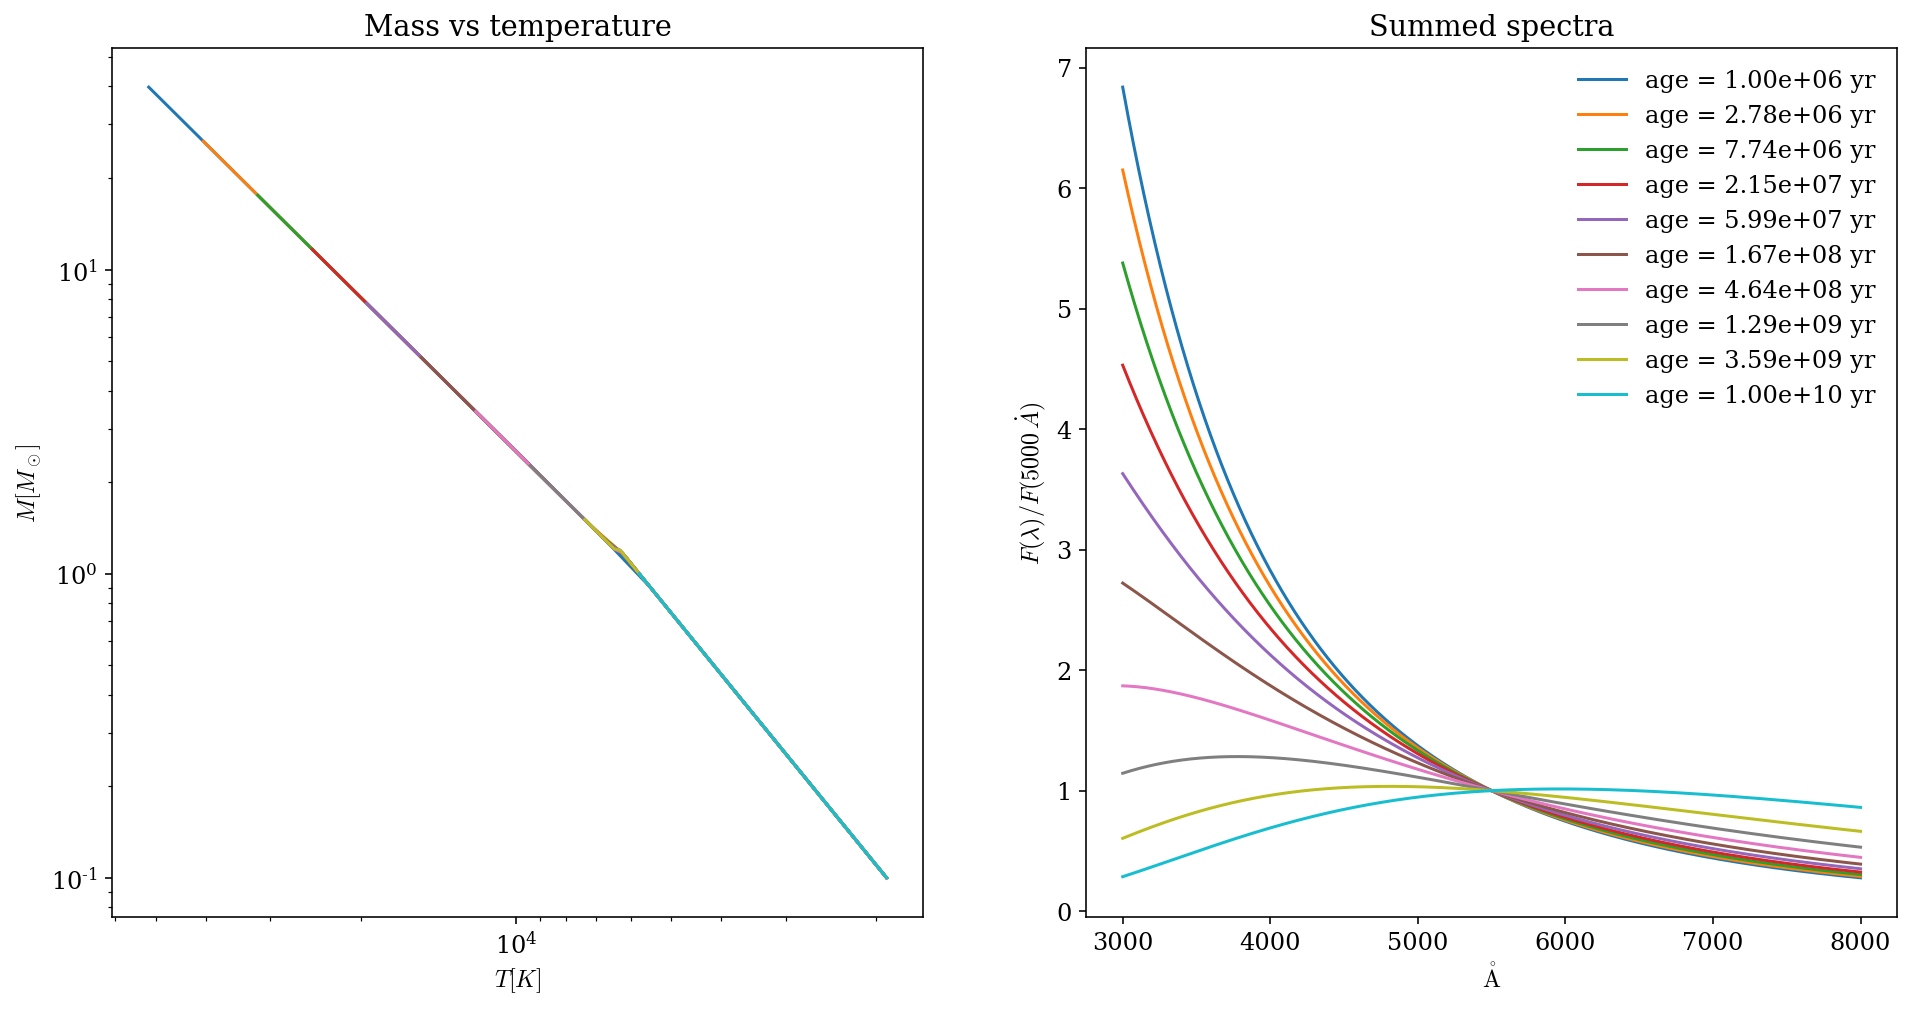

In [7]:
with quantity_support():
    #plt.figure() 
    fig, axs = plt.subplots(1, 2)
    for age in tqdm(ages): 
        M_max = max_mass(age, M_sun)
        M_array = np.linspace(M_min, M_max, 100)
        scale_factor_array, temp_array = np.hsplit(np.array([scale_and_temperature(M, M_sun) for M in M_array]), 2)
        
        axs[0].plot(temp_array, M_array / M_sun)
        
        bb = np.sum([models.BlackBody(temperature = T * u.K, scale = scale_factor * u.erg / (u.cm**2 * u.AA * u.s * u.sr)) for T,scale_factor in zip(temp_array, scale_factor_array)])
        flux = bb(wave)
        axs[1].plot(wave, flux / bb(5500 * u.AA), label = 'age = {:.2e}'.format(age)) #normalize to F(5000 A)
    
    #plt.plot(wave, flux) #normalize to F(5000 A) 
    
    axs[0].set_ylabel("$M [M_\odot]$")
    axs[0].set_xlabel("$T [K]$")
    axs[0].set_title("Mass vs temperature")
    axs[0].loglog()
    axs[0].invert_xaxis() 
    
    axs[1].set_ylabel("$F(\lambda) / F(5000 \, \dot{A})$")
    axs[1].legend(frameon = False)
    axs[1].set_title("Summed spectra")
    plt.show()

Only the galaxy with age $\tau \sim 10\, Gyr$ seems to reproduce the expected behaviour. What assumptions of the model can I relax? We assumed that all the stars forms in the same moment $\implies$ these galaxies contain only **one population** of stars. What if there is a second one?